# 1D Burgers Data-Driven Parameter Discovery Numerical

*Last edited: 2024-05-16*

This work is based on:

* *PySINDy* - [Sparse regression package](<https://pysindy.readthedocs.io/en/latest/examples/10_PDEFIND_examples/example.html#Test-PDE-functionality-on-Burgers'-equation>) with several implementations for the Sparse Identification of Nonlinear Dynamical systems (SINDy) method introduced in Brunton et al. (2016)

In [1]:
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import pysindy as ps
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz
import warnings
import numpy as np
# Seed for reproducibility
np.random.seed(1000)
# ignore user warnings
warnings.filterwarnings("ignore", category=UserWarning)

Burgers' equation is $u_t = 0.003183 u_{xx} - uu_x$, meaning:

$\displaystyle \frac{\partial u}{\partial t} = 0.003183 \frac{\partial^2u}{\partial x^2} - u \frac{\partial u}{\partial x}$

The original Burgers equation is

$$
\displaystyle \frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2} - u \frac{\partial u}{\partial x}
$$

for -1.0 < $x$ < +1.0

and $t$ > 0

Initial conditions are $u(x, 0) = - \sin(\pi x)$

Boundary conditions are $u(-1, t) = u(+1, t) = 0$

The viscosity parameter $\nu$ is taken to be $\frac{0.01}{\pi} = 0.003183$

The differential operator parameter $\lambda_1$ (or $u$) is the speed of fluid at the indicated spatial and temporal coordinates, the differential operator parameter $\lambda_2$ (or $\nu$) is the kinematic viscosity of fluid, and the subscripts denote partial differentiation in time and space, respectively, as
$u_t$ (which denotes $\frac{du}{dt}$), 
$u_x$ (which denotes $\frac{du}{dx}$), and 
$u_{xx}$ (which denotes $\frac{d^2u}{dx^2}$).

## Methods

* *STLSQ* - Sequentially thresholded least squares regression algorithm. Attempts to minimize the objective function by iteratively performing least squares and masking out elements of the weight that are below a given threshold.


<hr style="height:10px;border-width:0;background-color:green">

## Problem 01

viscosity = 0.01/np.pi

### 128x64

The "burgers_shock.mat" dataset is the same as that used by Raissi et al. (2019):

In [47]:
# Load data from .mat file
#data = loadmat('../data/burgers_shock.mat')
data = np.load('../data/burgers128x64.npz')
t = np.ravel(data['t'])  # ravel returns a contiguous flattened array
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

Show the dataset:

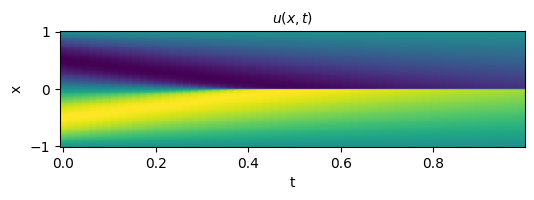

In [48]:
# Plot u
plt.figure(figsize=(6, 1.5))
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=10)
plt.ylabel('x', fontsize=10)
plt.title(r'$u(x, t)$', fontsize=10)
plt.show()

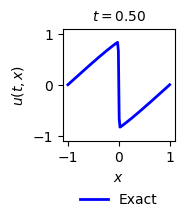

In [49]:
# u(t,x) slices
Exact = u.T
gs = gridspec.GridSpec(1, 1)
gs.update(top=1 - 1.0 / 3.0 - 0.1,
          bottom=1.0 - 2.0 / 3.0,
          left=0.1,
          right=0.9,
          wspace=0.5)
ax = plt.subplot(gs[0, 0])
ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=10)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.35),
          ncol=5,
          frameon=False)
plt.show()

### Solve the equation (inverse problem)

In [50]:
%%time

u = u.reshape(len(x), len(t), 1)
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3,
                        spatial_grid=x,
                        is_uniform=True)

print("Correct PDE: (u)' = 0.003183 u_11 - 1.0 uu_1")

Correct PDE: (u)' = 0.003183 u_11 - 1.0 uu_1
CPU times: user 880 µs, sys: 0 ns, total: 880 µs
Wall time: 830 µs


In [51]:
%%time

# STQL Sequentially thresholded least squares
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('Identified PDE using the STLSQ model: ')
model.print(precision=5)

Identified PDE using the STLSQ model: 
(u)' = 0.06420 u + 0.00505 u_11 + -1.06304 uu_1 + 0.00469 uuu_11 + -0.00001 uu_111
CPU times: user 65.1 ms, sys: 11.8 ms, total: 76.9 ms
Wall time: 39.5 ms


In [7]:
%%time

# FROL Forward Regression Orthogonal Least-Squares
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/frols.html
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-3)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('FROLs model: ')
model.print()

FROLs model: 
(u)' = -0.418 u
CPU times: user 863 ms, sys: 36.6 ms, total: 900 ms
Wall time: 186 ms


In [8]:
%%time

# SR3 Sparse relaxed regularized regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/sr3.html
optimizer = ps.SR3(threshold=2,
                   max_iter=10000,
                   tol=1e-15,
                   nu=1e2,
                   thresholder="l0",
                   normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SR3 model: ')
model.print()

SR3 model: 
(u)' = 0.064 u + 0.005 u_11 + -1.063 uu_1 + 0.005 uuu_11
CPU times: user 708 ms, sys: 8.76 ms, total: 717 ms
Wall time: 147 ms


In [9]:
%%time

# SSR Stepwise sparse regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/ssr.html
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SSR model: ')
model.print()

SSR model: 
(u)' = 0.064 u + 0.005 u_11 + -1.063 uu_1 + 0.005 uuu_11
CPU times: user 70.5 ms, sys: 0 ns, total: 70.5 ms
Wall time: 17 ms


## 256x128

In [10]:
# Load data from .mat file
#data = loadmat('../data/burgers_shock.mat')
data = np.load('../data/burgers256x128.npz')
t = np.ravel(data['t'])  # ravel returns a contiguous flattened array
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

In [11]:
%%time

u = u.reshape(len(x), len(t), 1)
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3,
                        spatial_grid=x,
                        is_uniform=True)

print("Correct PDE: (u)' = 0.003183 u_11 - 1.0 uu_1")

Correct PDE: (u)' = 0.003183 u_11 - 1.0 uu_1
CPU times: user 781 µs, sys: 0 ns, total: 781 µs
Wall time: 735 µs


In [12]:
%%time

# STQL Sequentially thresholded least squares
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('Identified PDE using the STLSQ model: ')
model.print(precision=5)

Identified PDE using the STLSQ model: 
(u)' = 0.00395 u_11 + -1.00869 uu_1 + 0.00126 uuu_11
CPU times: user 81.6 ms, sys: 40.5 ms, total: 122 ms
Wall time: 60.8 ms


In [13]:
%%time

# FROL Forward Regression Orthogonal Least-Squares
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/frols.html
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-3)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('FROLs model: ')
model.print()

FROLs model: 
(u)' = 0.015 u + 0.004 u_11 + -1.003 uu_1
CPU times: user 354 ms, sys: 5.15 ms, total: 359 ms
Wall time: 69.7 ms


In [14]:
%%time

# SR3 Sparse relaxed regularized regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/sr3.html
optimizer = ps.SR3(threshold=2,
                   max_iter=10000,
                   tol=1e-15,
                   nu=1e2,
                   thresholder="l0",
                   normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SR3 model: ')
model.print()

SR3 model: 
(u)' = 0.004 u_11 + -1.009 uu_1 + 0.001 uuu_11
CPU times: user 860 ms, sys: 24.6 ms, total: 884 ms
Wall time: 236 ms


In [15]:
%%time

# SSR Stepwise sparse regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/ssr.html
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SSR model: ')
model.print()

SSR model: 
(u)' = 0.011 u + 0.004 u_11 + -1.011 uu_1 + 0.001 uuu_11
CPU times: user 211 ms, sys: 45.5 ms, total: 257 ms
Wall time: 42.7 ms


## 512x256

In [41]:
# Load data from .mat file
#data = loadmat('../data/burgers_shock.mat')
data = np.load('../data/burgers512x256.npz')
t = np.ravel(data['t'])  # ravel returns a contiguous flattened array
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

In [42]:
%%time

u = u.reshape(len(x), len(t), 1)
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3,
                        spatial_grid=x,
                        is_uniform=True)

print("Correct PDE: (u)' = 0.003183 u_11 - 1.0 uu_1")

Correct PDE: (u)' = 0.003183 u_11 - 1.0 uu_1
CPU times: user 446 µs, sys: 0 ns, total: 446 µs
Wall time: 401 µs


In [43]:
%%time

# STQL Sequentially thresholded least squares
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('Identified PDE using the STLSQ model: ')
model.print(precision=5)

Identified PDE using the STLSQ model: 
(u)' = 0.00339 u_11 + -1.00534 uu_1 + 0.00041 uuu_11
CPU times: user 346 ms, sys: 36.1 ms, total: 382 ms
Wall time: 118 ms


In [44]:
%%time

# FROL Forward Regression Orthogonal Least-Squares
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/frols.html
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-3)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('FROLs model: ')
model.print()

FROLs model: 
(u)' = 0.006 u + 0.004 u_11 + -1.006 uu_1
CPU times: user 3.33 s, sys: 94.7 ms, total: 3.42 s
Wall time: 632 ms


In [45]:
%%time

# SR3 Sparse relaxed regularized regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/sr3.html
optimizer = ps.SR3(threshold=2,
                   max_iter=10000,
                   tol=1e-15,
                   nu=1e2,
                   thresholder="l0",
                   normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SR3 model: ')
model.print()

SR3 model: 
(u)' = 0.003 u_11 + -1.005 uu_1
CPU times: user 339 ms, sys: 35.7 ms, total: 375 ms
Wall time: 117 ms


In [46]:
%%time

# SSR Stepwise sparse regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/ssr.html
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SSR model: ')
model.print()

SSR model: 
(u)' = 0.006 u + 0.003 u_11 + -1.007 uu_1
CPU times: user 808 ms, sys: 36.5 ms, total: 845 ms
Wall time: 196 ms


<hr style="height:10px;border-width:0;background-color:green">

## Problem 02

viscosity = 0.1/np.pi

### 128x64

In [20]:
# Load data from .mat file
#data = loadmat('../data/burgers-pysindy.mat')
data = np.load('../data/burgers128x64-02.npz')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

Show the dataset:

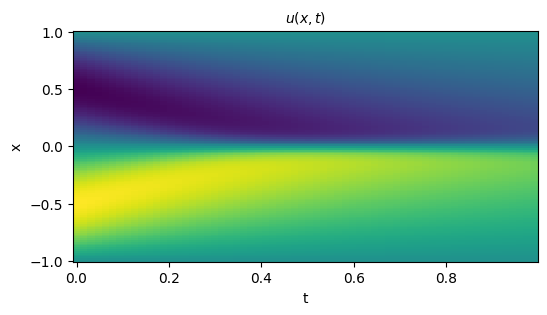

In [21]:
# Plot u
plt.figure(figsize=(6, 3))
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=10)
plt.ylabel('x', fontsize=10)
plt.title(r'$u(x, t)$', fontsize=10)
plt.show()

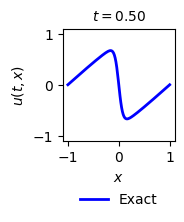

In [22]:
# u(t,x) slices
Exact = u.T
gs = gridspec.GridSpec(1, 1)
gs.update(top=1 - 1.0 / 3.0 - 0.1,
          bottom=1.0 - 2.0 / 3.0,
          left=0.1,
          right=0.9,
          wspace=0.5)
ax = plt.subplot(gs[0, 0])
ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=10)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.35),
          ncol=5,
          frameon=False)
plt.show()

In [23]:
%%time

u = u.reshape(len(x), len(t), 1)
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3,
                        spatial_grid=x,
                        is_uniform=True)

print("Correct PDE: (u)' = 0.03183 u_11 - 1.0 uu_1")

Correct PDE: (u)' = 0.03183 u_11 - 1.0 uu_1
CPU times: user 741 µs, sys: 94 µs, total: 835 µs
Wall time: 785 µs


In [24]:
%%time

# STQL Sequentially thresholded least squares
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('Identified PDE using the STLSQ model: ')
model.print(precision=5)

Identified PDE using the STLSQ model: 
(u)' = 0.03222 u_11 + -1.00012 uu_1
CPU times: user 25.5 ms, sys: 0 ns, total: 25.5 ms
Wall time: 10.5 ms


In [25]:
%%time

# FROL Forward Regression Orthogonal Least-Squares
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/frols.html
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-3)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('FROLs model: ')
model.print()

FROLs model: 
(u)' = 0.032 u_11 + -1.000 uu_1
CPU times: user 170 ms, sys: 14.3 ms, total: 184 ms
Wall time: 39 ms


In [26]:
%%time

# SR3 Sparse relaxed regularized regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/sr3.html
optimizer = ps.SR3(threshold=2,
                   max_iter=10000,
                   tol=1e-15,
                   nu=1e2,
                   thresholder="l0",
                   normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SR3 model: ')
model.print()

SR3 model: 
(u)' = 0.032 u_11 + -1.000 uu_1
CPU times: user 18.3 ms, sys: 1.25 ms, total: 19.6 ms
Wall time: 6.82 ms


In [27]:
%%time

# SSR Stepwise sparse regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/ssr.html
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SSR model: ')
model.print()

SSR model: 
(u)' = 0.003 u + 0.032 u_11 + -1.002 uu_1
CPU times: user 273 ms, sys: 3.07 ms, total: 276 ms
Wall time: 61.4 ms


## 256x128

In [28]:
data = np.load('../data/burgers256x128-02.npz')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

In [29]:
%%time

u = u.reshape(len(x), len(t), 1)
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3,
                        spatial_grid=x,
                        is_uniform=True)

print("Correct PDE: (u)' = 0.03183 u_11 - 1.0 uu_1")

Correct PDE: (u)' = 0.03183 u_11 - 1.0 uu_1
CPU times: user 683 µs, sys: 76 µs, total: 759 µs
Wall time: 715 µs


In [30]:
%%time

# STQL Sequentially thresholded least squares
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('Identified PDE using the STLSQ model: ')
model.print(precision=5)

Identified PDE using the STLSQ model: 
(u)' = 0.03193 u_11 + -1.00002 uu_1
CPU times: user 52.5 ms, sys: 5.38 ms, total: 57.9 ms
Wall time: 23.4 ms


In [31]:
%%time

# FROL Forward Regression Orthogonal Least-Squares
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/frols.html
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-3)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('FROLs model: ')
model.print()

FROLs model: 
(u)' = 0.032 u_11 + -1.000 uu_1
CPU times: user 382 ms, sys: 6.83 ms, total: 389 ms
Wall time: 74.5 ms


In [32]:
%%time

# SR3 Sparse relaxed regularized regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/sr3.html
optimizer = ps.SR3(threshold=2,
                   max_iter=10000,
                   tol=1e-15,
                   nu=1e2,
                   thresholder="l0",
                   normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SR3 model: ')
model.print()

SR3 model: 
(u)' = 0.032 u_11 + -1.000 uu_1
CPU times: user 82.7 ms, sys: 0 ns, total: 82.7 ms
Wall time: 13.8 ms


In [33]:
%%time

# SSR Stepwise sparse regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/ssr.html
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SSR model: ')
model.print()

SSR model: 
(u)' = 0.001 u + 0.032 u_11 + -1.000 uu_1
CPU times: user 113 ms, sys: 4.07 ms, total: 117 ms
Wall time: 28.4 ms


## 512x256

In [34]:
data = np.load('../data/burgers512x256-02.npz')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

In [35]:
%%time

u = u.reshape(len(x), len(t), 1)
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3,
                        spatial_grid=x,
                        is_uniform=True)

print("Correct PDE: (u)' = 0.03183 u_11 - 1.0 uu_1")

Correct PDE: (u)' = 0.03183 u_11 - 1.0 uu_1
CPU times: user 744 µs, sys: 73 µs, total: 817 µs
Wall time: 766 µs


In [36]:
%%time

# STQL Sequentially thresholded least squares
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('Identified PDE using the STLSQ model: ')
model.print(precision=5)

Identified PDE using the STLSQ model: 
(u)' = 0.03186 u_11 + -1.00001 uu_1
CPU times: user 226 ms, sys: 19 ms, total: 245 ms
Wall time: 75.2 ms


In [37]:
%%time

# FROL Forward Regression Orthogonal Least-Squares
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/frols.html
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-3)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('FROLs model: ')
model.print()

FROLs model: 
(u)' = 0.032 u_11 + -1.000 uu_1
CPU times: user 3.12 s, sys: 99.5 ms, total: 3.22 s
Wall time: 615 ms


In [38]:
%%time

# SR3 Sparse relaxed regularized regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/sr3.html
optimizer = ps.SR3(threshold=2,
                   max_iter=10000,
                   tol=1e-15,
                   nu=1e2,
                   thresholder="l0",
                   normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SR3 model: ')
model.print()

SR3 model: 
(u)' = 0.032 u_11 + -1.000 uu_1
CPU times: user 430 ms, sys: 23.8 ms, total: 454 ms
Wall time: 75.5 ms


In [39]:
%%time

# SSR Stepwise sparse regression
# https://pysindy.readthedocs.io/en/latest/_modules/pysindy/optimizers/ssr.html
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib,
                 optimizer=optimizer,
                 feature_names=["u"])
model.fit(u, t=dt)
print('SSR model: ')
model.print()

SSR model: 
(u)' = 0.032 u_11 + -1.000 uu_1
CPU times: user 1.38 s, sys: 62.5 ms, total: 1.45 s
Wall time: 301 ms


---
## References

Brunton, S. L., Proctor, J. L., & Kutz, J. N. (2016). Discovering governing equations from data by sparse identification of nonlinear dynamical systems. Proceedings of the National Academy of Sciences, 113(15), 3932–3937. https://doi.org/10.1073/pnas.1517384113

Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational Physics, 378, 686–707. https://doi.org/10.1016/j.jcp.2018.10.045


<hr style="height:10px;border-width:0;background-color:gray">

## Environment

In [40]:
%%bash
source $HOME/miniconda3/bin/activate psin
conda list --explicit > Burgers-1D-Discovery-Numerical-environment.txt